# Team learning on genAI dashboards

## How does it work?

https://miro.com/app/board/o9J_ldRDmCQ=/

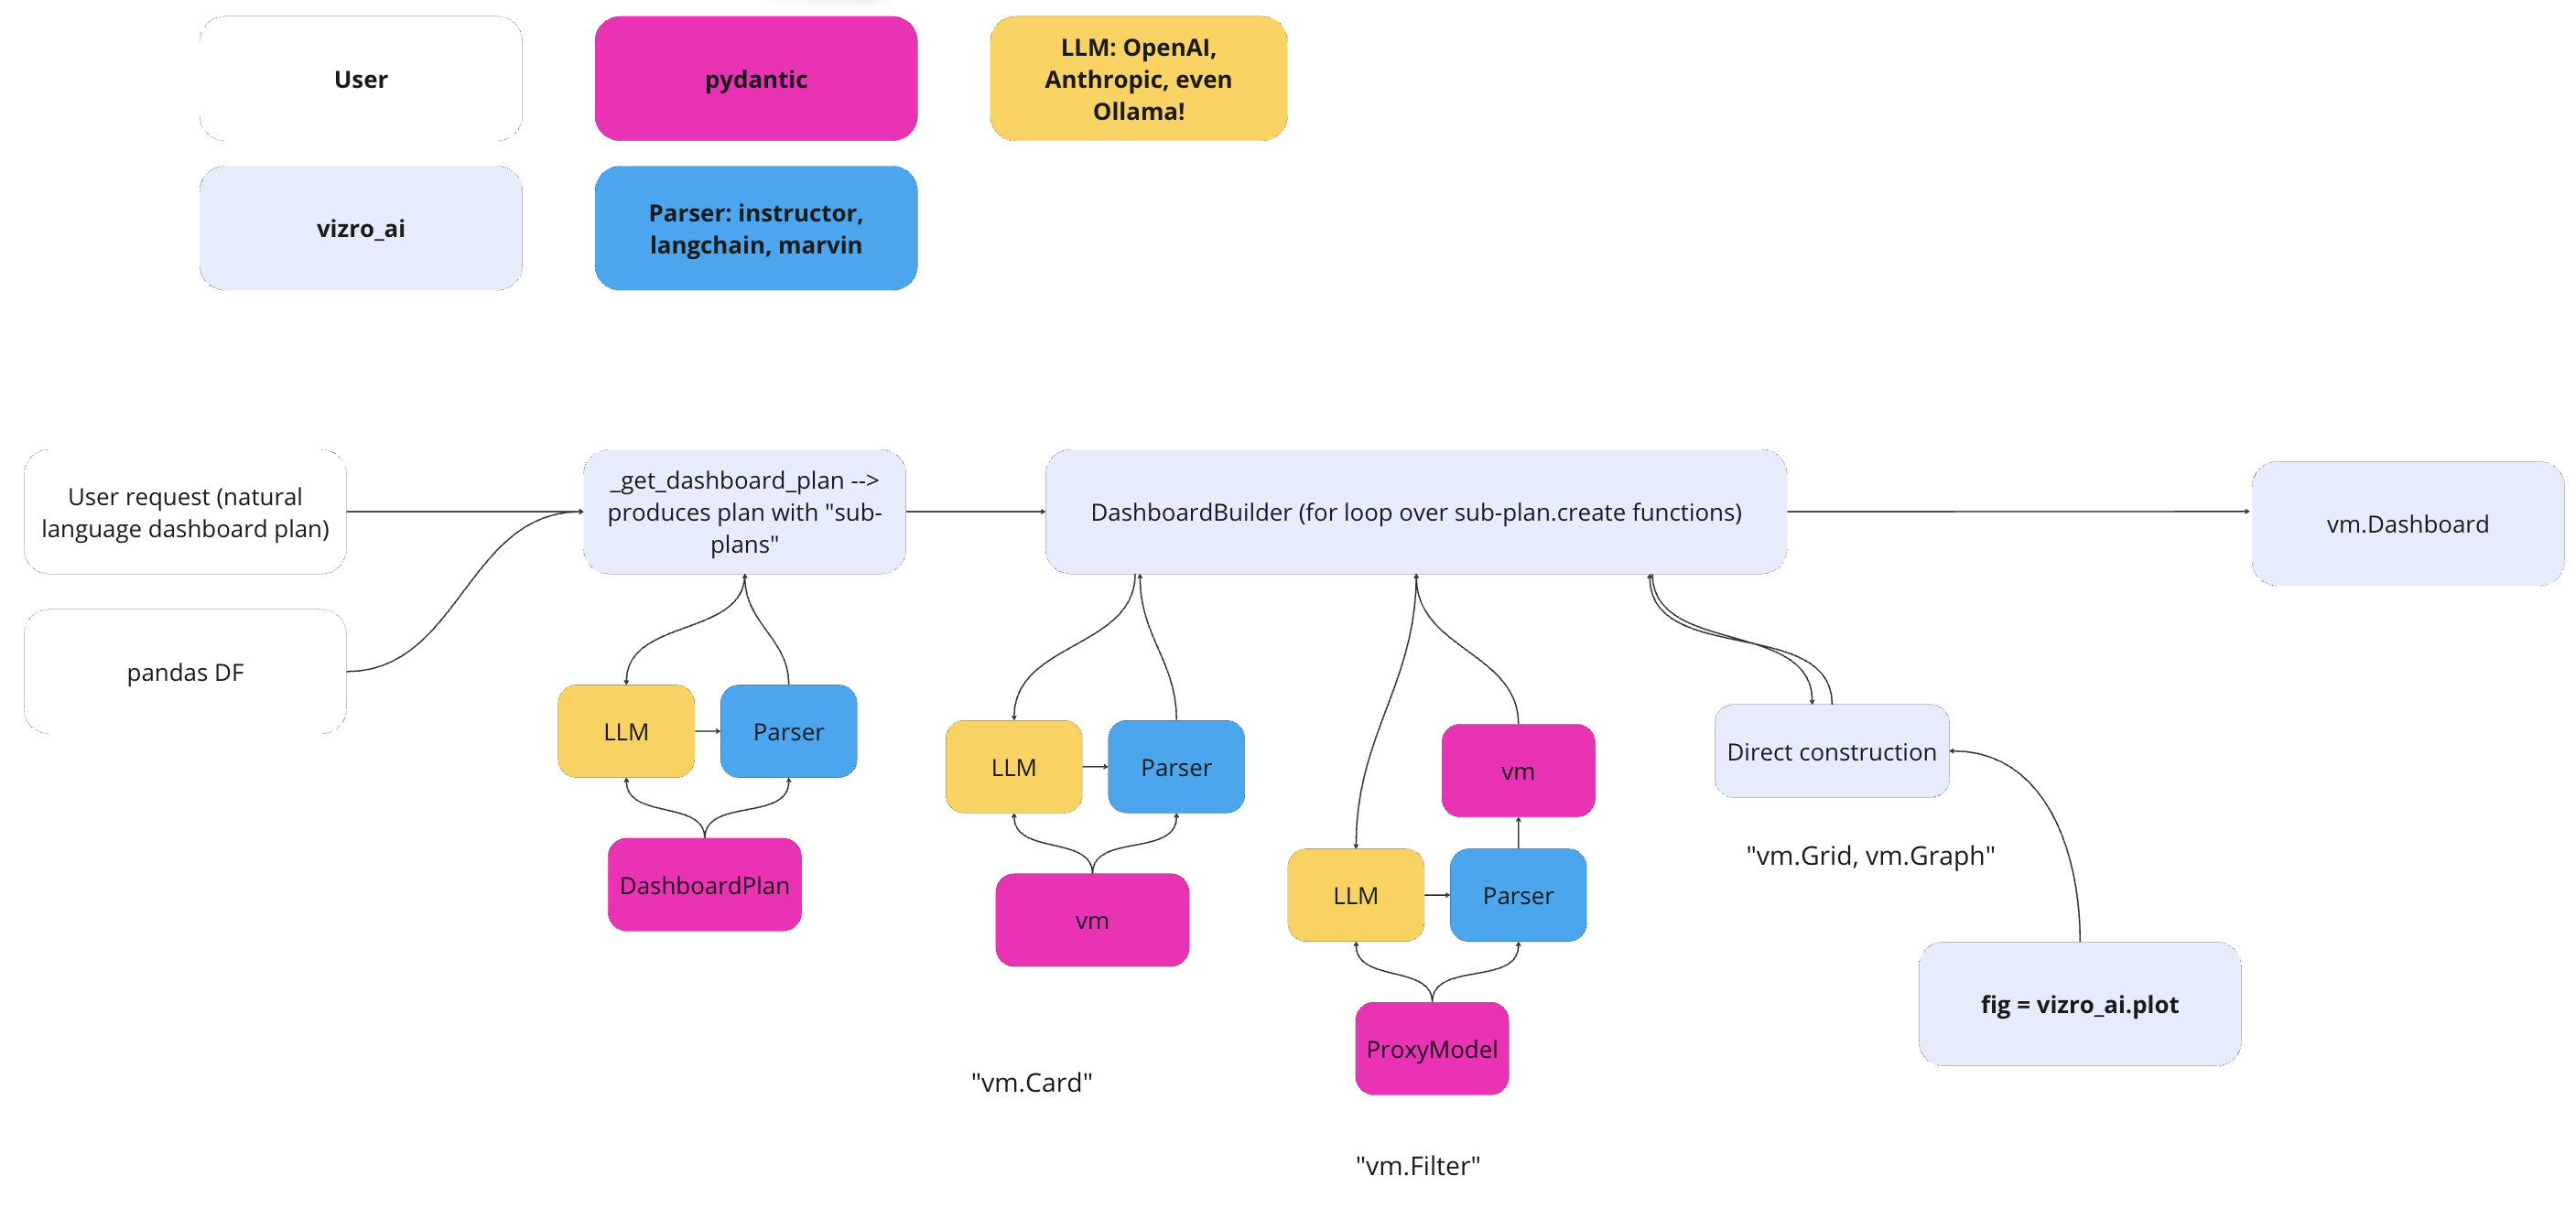

In [1]:
from IPython import display
display.Image("/Users/Maximilian_Schulz/Library/CloudStorage/OneDrive-McKinsey&Company/Documents/3 - Screenshots/genai_arch.png")

### Pros

- Leveraging `pydantic` and thus the power of data validation
- Validated data gives stability and reproducability
- Modular approach allows status bars, fallback options, different sub approaches and potentially! iteration
- Very model agnostic, already proven to work with OpenAI and Anthropic, no reason why eventually Ollama should not work!
- Safety: currently `vizro_ai` is the only LLM created code we run, no additional code is run, thus no security risk
- Re-use of `vizro_ai`
- Cost: no RAG reduces tokens massively, thus lowering costs, expensive models often not needed
- Generally: Vizro very powerful due to declarative approach - e.g. filter works very well when NOT specifying a selector

### Cons

- Tool only as good as we enable/maintain it
- very custom things might not be possible / much harder to do (e.g. custom actions or custom components)
- more Proxy models than expected
- model_manager not working well together with Proxy models
- so far only one parser supports pydantic V1

## The heart: Pydantic and Parsers

### Instructor

In [2]:
from dotenv import load_dotenv
load_dotenv()
import enum
from pydantic import BaseModel, Field, field_validator
import instructor
from openai import OpenAI
from typing import Literal, Optional, List, Union
import openai
import instructor

from typing import Iterable, Literal
from pydantic import BaseModel

In [3]:
# Patch the OpenAI client
client = instructor.from_openai(OpenAI())

# Here's another example, but with a compound typed field.
class Actor(BaseModel):
    name: str = Field(description="name of an actor")
    country_origin: str = Field(description="Country they were born in")

    @field_validator('country_origin')
    @classmethod
    def country_upper(cls, v: str) -> str:
        if not v.isupper():
            raise ValueError('Must be all caps!')
        return v


actor_query = "Generate the info for a random actor that is not from the US."

actor = client.chat.completions.create(
    model="gpt-3.5-turbo",
    max_retries=3, # Retry the request 3 times
    response_model=Actor,
    messages=[
        {"role": "system", "content": actor_query},
    ],
)
actor

Actor(name='Gael García Bernal', country_origin='MEXICO')

#### Cool example: Parallel function calling

In [4]:
class Weather(BaseModel):
    location: str
    units: Literal["imperial", "metric"]


class GoogleSearch(BaseModel):
    query: str


client = instructor.patch(openai.OpenAI(), mode=instructor.Mode.PARALLEL_TOOLS)  

function_calls = client.chat.completions.create(
    model="gpt-4-turbo-preview",
    messages=[
        {"role": "system", "content": "You must always use tools"},
        {
            "role": "user",
            "content": "What is the weather in toronto and dallas and who won the super bowl?",
        },
    ],
    response_model=Iterable[Union[Weather, GoogleSearch]],  
)

for fc in function_calls:
    print(fc)
    #> location='Toronto' units='metric'
    #> location='Dallas' units='imperial'
    #> query='super bowl winner'

location='Toronto' units='metric'
location='Dallas' units='imperial'
query='Super Bowl winner'


### Other tools and comparison

#### Instructor

Very slick library that provides a very clear interface with the underlying model

PRO:
- instantiates Pydantic models with ease
- very simple and intuitive API
- support for more complex technologies
- easy support for other model vendors (not sure if this would also hold for marvin)

CON:
- only pydantic V2
- one man show, but a good one!

#### Langchain

Langchain offers a slightly more verbose way of doing things, but at the same time is not bad in how it is structured!

PRO:
- super well supported
- supports pydantic V1!
- supports multiple models in similar API

CON:
- does not have retry
- slightly verbose in setting up things

#### Marvin


It looks like Marvin is really slick and easy to use so far.

PRO:
- instantiates Pydantic models with ease
- very simple and intuitive API
- support for assistant and more complex workflow, but at the heart very simple

CON:
- very much focussed on OpenAI
- not the clearest view on model settings, although it seems possible to some extent
- no natural retry (I think)

Still to verify:
- how will it deal with Vizro Pydantic models
- "pydantic>=2.4.2"

In [5]:
import marvin
class Location(BaseModel):
    city: str
    state: str

locations = marvin.generate(
    n=4,
    target=Location,
    instructions="US cities named after presidents",
)
locations

[Location(city='Jefferson City', state='Missouri'),
 Location(city='Madison', state='Wisconsin'),
 Location(city='Jackson', state='Mississippi'),
 Location(city='Lincoln', state='Nebraska')]

#### Guardrail

Didn't get it to run... but has similar features as above, and is further focussed on safeguarding responses

## Estimating future feature

Relatively easy
- layout
- advanced navigation

Moderate
- pre-defined actions
- advanced tables

Hard
- Parameters
- custom actions and components